# Experimenting with Data Collection and Collaborative Filtering for Nintendo Recommender System

In [5]:
#importing necessary libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [ ]:
#URL link for user Link3710
url = "https://www.nintendolife.com/users/link3710/games"
r = requests.get(url)

In [ ]:
#formatting as soup
html_text = r.text

soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
#Checking out the head
print(soup.prettify)

In [ ]:
#Checking out the title
print(soup.title)

In [ ]:
#Checking out body
print(soup.body)

In [ ]:
games = soup.findAll("p")

In [ ]:
len(games)

In [ ]:
for i in range(len(games)):
    print(games[i])
    print('\n')

It looks like I need to find every p where class = "heading" or class = "description" - how can I do that?

In [ ]:
games[10]

In [ ]:
type(games[10])

In [ ]:
games[10].name

In [ ]:
games[10].attrs

In [ ]:
soup.a

In [ ]:
soup.findAll("a")

Seems like all of the game titles are in the a class and the game descriptions are in the p class

In [ ]:
game_titles = soup.findAll("a")

In [ ]:
game_titles[42].attrs

In [ ]:
spans = soup.findAll("span")

In [ ]:
spans

In [ ]:
spans[94].contents[0]

In [ ]:
spans[96].contents[0]

In [ ]:
spans[94]

In [ ]:
spans[94].attrs

In [ ]:
if spans[94]["class"] == ['title', 'accent-hover']:
    print(True)

In [ ]:
spans[95]

In [ ]:
spans[95].attrs

In [ ]:
if spans[95]["class"] == ["subtitle"]: 
    print(True)
else:
    print(False)

In [ ]:
spans[96]

In [ ]:
spans[96].attrs

In [ ]:
spans[94].contents

In [ ]:
spans[96].contents

In [ ]:
#I'm going to set up a dataframe with 3 columns - user, game and rating

cols = ["User", "Game", "Rating"]

df = pd.DataFrame(columns = cols)

In [ ]:
len(spans)

In [ ]:
games = []
ratings = []

for i in range(len(spans)):
    try:
        if spans[i]["class"] == ["title", "accent-hover"]:
            games.append(spans[i].contents[0])
            if spans[i+2]["class"] == ["value"]:
                ratings.append(spans[i+2].contents[0])
            else:
                ratings.append("No Score")
    except KeyError:
        pass
    
if len(games) > len(ratings):
    ratings.append("No Score")

In [ ]:
print(games)
print(ratings)

In [ ]:
df["Game"] = games
df["Rating"] = ratings

In [ ]:
df["User"] = "link3710"

In [ ]:
df.head(10)

Next Steps: Figure out pagination, figure out how to pull multiple users

The pagination element of the page is tagged in the following manner: <br>
"< nav class ="ui-listing-pagination" > <br>
There are then child tags equal to the number of pages that a given user has, with the last page tagged as follows: <br>
< li class = "last" > <br>
Within that last class is contained a class that looks like this: <br>
< a class="accent accent-bg-hover accent-border" href="/users/link3710/games?sort=date&amp;status=own&amp;style=tile&amp;page=4" title="Goto Page 4">4</ a>
<br>
I need to get the contents of that last tag out.


In [ ]:
#last tag
my_page_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})

In [ ]:
my_page_tags

In [ ]:
page_tags = []
for tag in my_page_tags:
    page_tags.append(int(tag.contents[0]))
    
print(page_tags)

In [ ]:
max_page_tags = max(page_tags)

In [ ]:
max_page_tags = int(max_page_tags)

In [ ]:
max_page_tags

In [ ]:
max_page_tags * 2

In order to get the data for multiple users, I'll have to have the usernames stored in another object prior to requesting my pages, so for now, I'm not going to worry about programmatically retrieving the username from a given user's page.

In [27]:
#Creating Function for getting max pages

def get_max_pages(user_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our user
    url = "https://www.nintendolife.com/users/" + user_name + "/games"
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a user only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [3]:
print(get_max_pages("link3710"))

4


In [4]:
#Creating Function for getting games and ratings into dataframe=
def games_ratings_to_df(user_name, max_pages):
    '''Function for putting a user's games
    and ratings into a dataframe'''
    
    #Setting up object holders
    cols = ["User", "Game", "Rating"]
    df = pd.DataFrame(columns=cols)
    games = []
    ratings = []
    
    #iterating through pages
    for page in range(1, max_pages+1):
        #Url is different if on first page rather than other pages
        if page == 1:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games"
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
        #Adding the rest of the url pages       
        else:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games?page=" + str(page)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
    
    #Adding our games and ratings list to dataframe
    df["Game"] = games
    df["Rating"] = ratings
    df["User"] = user_name
    
    return df

In [5]:
link3710_ratings = games_ratings_to_df("link3710", 4)
print(link3710_ratings.head(10))
print(link3710_ratings.shape)

       User                        Game    Rating
0  link3710            Daemon X Machina  No Score
1  link3710     Spyro Reignited Trilogy         9
2  link3710                 Gato Roboto         8
3  link3710         DELTARUNE Chapter 1         9
4  link3710  Super Smash Bros. Ultimate        10
5  link3710      Katamari Damacy REROLL         9
6  link3710         Horizon Chase Turbo         8
7  link3710        Dragon Ball FighterZ         8
8  link3710                   Undertale         9
9  link3710                    Okami HD         9
(189, 3)


In [5]:
link3710_pages = get_max_pages("link3710")
link3710_ratings = games_ratings_to_df("link3710", link3710_pages)

In [6]:
link3710_ratings.head(10)

,User,Game,Rating
0,link3710,Daemon X Machina,No Score
1,link3710,Spyro Reignited Trilogy,9
2,link3710,Gato Roboto,8
3,link3710,DELTARUNE Chapter 1,9
4,link3710,Super Smash Bros. Ultimate,10
5,link3710,Katamari Damacy REROLL,9
6,link3710,Horizon Chase Turbo,8
7,link3710,Dragon Ball FighterZ,8
8,link3710,Undertale,9
9,link3710,Okami HD,9


In [7]:
link3710_ratings.tail(10)

,User,Game,Rating
179,link3710,Donkey Kong,10
180,link3710,The Legend of Zelda: Link's Awakening,10
181,link3710,Kirby's Dream Land,7
182,link3710,Final Fantasy Adventure,7
183,link3710,Final Fantasy Legend II,8
184,link3710,The Hunt for Red October,9
185,link3710,Dr. Mario,8
186,link3710,Gargoyle's Quest,7
187,link3710,QIX,8
188,link3710,Pinball: Revenge of the 'Gator,9


### Function for Pulling Users

My first idea for pulling users would be to iterate through a long-running thread from the NintendoLife forums and pull out the user names, and then dedupe them. 

The page URLs for the forum posts go by multiples of 20 - one page can only have a max of 20 posts. 
I could go to the last page of the thread, subtract by 1 (because of the page sequencing), and multiply by 20 to get the #start parameter of the URL Thread.

But, to start, I need to be able to get the max number of pages from a thread programatically. I'm going to try to reproduce my get_max_pages function from the user page and modify it for forum pages.

In [ ]:
#Setting parameters and getting soup for our thread

thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
page_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"})

In [ ]:
page_tags

In [28]:
def get_max_pages_thread(thread_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our thread
    url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a thread only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [8]:
max_pages_thread = get_max_pages_thread("what_do_you_think_the_nx_is_poll")
print(max_pages_thread)

2374


In [ ]:
for i in range(max_pages_thread):
    print(i*20)

Lucikly, the url query sequencing within the thread has the same bounds as python printing - what I mean by that is, the iteration value is 0 when starting at the first page, and then increases in 20s - the same bounds as the thread start= query value. <br> 
<br>
Now, I need to find how to pull out all of the user names from the forum pages.

In [ ]:
#Setting parameters and getting soup for our thread

thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
user_names = soup.findAll("a", {"class": "accent username"})

In [ ]:
for user in user_names:
    print(user.contents[0])

In [ ]:
max_pages_thread

In [ ]:
thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

for i in range(max_pages_thread):
    n_posts = i * 20
    if n_posts == 0:
        print(url)
    else:
        print(url + "?start=" + str(n_posts))

In [29]:
#Now lets try to collect for multiple users

def get_users(thread_name, max_pages):
    '''Function for collecting all users from a thread. 
    Params: thread name (string), max number of pages
    returns :De-duplicated list of users'''
    
    users = []
    for i in range(max_pages):
        n_posts = i * 20
        if n_posts == 0:            
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])

        else:           
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name + "?start=" + str(n_posts)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])
                
    #Deduplicating List
    deduped_users = list(set(users))
    return deduped_users

In [10]:
thread_pages = get_max_pages_thread("the_switch_eshop_recommendations")
thread_users = get_users("the_switch_eshop_recommendations", thread_pages)

In [11]:
df = pd.DataFrame()
for user in thread_users:
    max_pages = get_max_pages(user)
    user_games_ratings = games_ratings_to_df(user, max_pages)
    df = df.append(user_games_ratings)

In [12]:
df.head()

,User,Game,Rating
0,splatmax,Super Smash Bros. Ultimate,No Score
1,splatmax,Super Mario Odyssey,10
2,splatmax,Splatoon 2,9
3,splatmax,Mario Kart 8 Deluxe,9
4,splatmax,Snake Pass,7


In [13]:
df.tail()

,User,Game,Rating
9,Minch,The Binding of Isaac: Afterbirth+,No Score
10,Minch,The Legend of Zelda: Breath of the Wild,No Score
11,Minch,Fast RMX,No Score
12,Minch,Metroid Prime: Hunters,10
13,Minch,The Urbz: Sims in the City,7


In [22]:
df["User"].nunique()

170

In [23]:
df["Game"].value_counts()

The Legend of Zelda: Breath of the Wild       123
Super Mario Odyssey                            87
Mario Kart 8 Deluxe                            78
Splatoon 2                                     59
The Legend of Zelda: Link's Awakening          56
Mario + Rabbids Kingdom Battle                 51
Super Smash Bros. Ultimate                     48
Donkey Kong Country: Tropical Freeze           48
Super Mario 3D World                           44
Bayonetta 2                                    43
Mario Kart 8                                   41
The Legend of Zelda: Ocarina of Time 3D        41
Super Mario Maker                              40
Super Mario Galaxy 2                           39
Super Smash Bros. for Wii U                    38
Splatoon                                       37
The Legend of Zelda: A Link Between Worlds     36
Bayonetta                                      35
The Legend of Zelda: Twilight Princess         34
Super Mario 3D Land                            34


In [24]:
df.shape

(10140, 3)

In [25]:
df["Rating"].value_counts()

No Score    3295
8           1863
9           1821
7           1208
10          1197
6            424
5            153
4             67
1             41
3             37
2             34
Name: Rating, dtype: int64

In [26]:
rated_df = df[df["Rating"] != "No Score"]

In [27]:
rated_df["Rating"].value_counts()

8     1863
9     1821
7     1208
10    1197
6      424
5      153
4       67
1       41
3       37
2       34
Name: Rating, dtype: int64

In [28]:
rated_df.shape

(6845, 3)

In [29]:
rated_df.groupby("Rating").count()

,User,Game
Rating,,
1,41,41
10,1197,1197
2,34,34
3,37,37
4,67,67
5,153,153
6,424,424
7,1208,1208
8,1863,1863


In [31]:
# Importing the data into surprise for start with our algorithm
from surprise import Reader, Dataset, accuracy

reader = Reader(rating_scale=(1, 10))
game_data = Dataset.load_from_df(rated_df[['User', 'Game', 'Rating']], reader)

In [33]:
game_data.raw_ratings

[('New_Guest', 'Donkey Kong Land', 9.0, None),
 ('New_Guest', 'Wario Land: Super Mario Land 3', 10.0, None),
 ('New_Guest', "The Legend of Zelda: Link's Awakening", 10.0, None),
 ('New_Guest', 'Super Mario Land 2: 6 Golden Coins', 10.0, None),
 ('New_Guest',
  'Teenage Mutant Ninja Turtles II: Back from the Sewers',
  10.0,
  None),
 ('New_Guest', 'Nintendo World Cup', 8.0, None),
 ('New_Guest',
  'Teenage Mutant Ninja Turtles: Fall of the Foot Clan',
  10.0,
  None),
 ('New_Guest', 'Super Mario Land', 10.0, None),
 ('New_Guest', 'Tetris', 10.0, None),
 ('Magician', "Dragon's Dogma: Dark Arisen", 9.0, None),
 ('Magician', 'Our World is Ended', 4.0, None),
 ('Magician', 'RICO', 8.0, None),
 ('Magician', 'The Caligula Effect: Overdose', 6.0, None),
 ('Magician', 'Rad Rodgers Radical \ufeffEdition', 7.0, None),
 ('Magician', 'RemiLore', 7.0, None),
 ('Magician', 'Reverie: Sweet As Edition', 8.0, None),
 ('Magician', 'RIOT - Civil Unrest', 4.0, None),
 ('Magician', 'Sphinx and the Cursed M

In [34]:
game_df = pd.DataFrame(game_data.raw_ratings, columns=['User', 'Item', 'Rating', 'Unused'])
game_df.groupby("Rating").count()

,User,Item,Unused
Rating,,,
1.0,41,41,0
2.0,34,34,0
3.0,37,37,0
4.0,67,67,0
5.0,153,153,0
6.0,424,424,0
7.0,1208,1208,0
8.0,1863,1863,0
9.0,1821,1821,0


In [37]:
#80-20 split for train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(game_data, test_size=.2)

In [38]:
print("Number of users: ", trainset.n_users)
print("Number of items: ", trainset.n_items)
print("Density: ", (trainset.n_ratings/(trainset.n_users * trainset.n_items)))

Number of users:  139
Number of items:  1908
Density:  0.020647632837126527


In [39]:
trainset.n_ratings

5476

In [45]:
game_df.head()

,User,Item,Rating,Unused
0,New_Guest,Donkey Kong Land,9.0,None
1,New_Guest,Wario Land: Super Mario Land 3,10.0,None
2,New_Guest,The Legend of Zelda: Link's Awakening,10.0,None
3,New_Guest,Super Mario Land 2: 6 Golden Coins,10.0,None
4,New_Guest,Teenage Mutant Ninja Turtles II: Back from the...,10.0,None


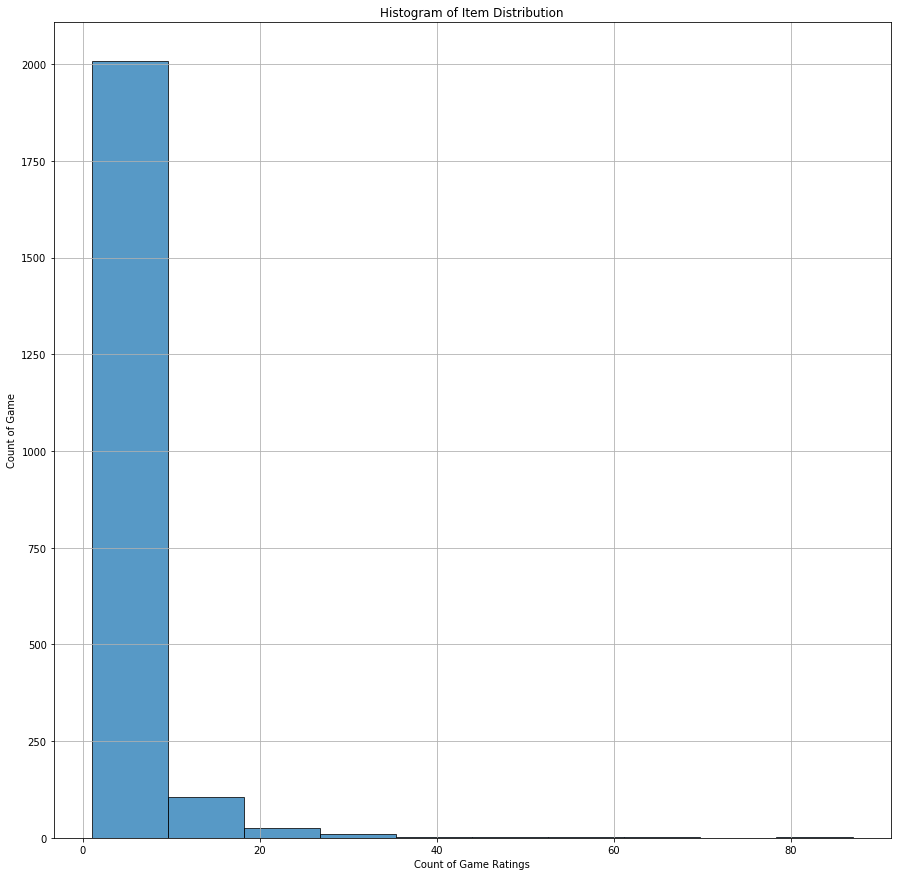

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.xlabel('Count of Game Ratings')
plt.ylabel('Count of Game')
plt.title('Histogram of Item Distribution')
plt.grid(True)
#log=True, bins=30,
plt.hist(game_df.groupby("Item")["Rating"].count(), bins=10, alpha=0.75, edgecolor='black')
plt.show()

Lots of games that were only rated a 1-10 times, a lot fewer games that were rated 40+ times

(array([68., 20., 18.,  8., 10.,  4.,  2.,  1.,  1.,  3.,  1.,  1.,  2.,
         0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  1.        ,  19.06666667,  37.13333333,  55.2       ,
         73.26666667,  91.33333333, 109.4       , 127.46666667,
        145.53333333, 163.6       , 181.66666667, 199.73333333,
        217.8       , 235.86666667, 253.93333333, 272.        ,
        290.06666667, 308.13333333, 326.2       , 344.26666667,
        362.33333333, 380.4       , 398.46666667, 416.53333333,
        434.6       , 452.66666667, 470.73333333, 488.8       ,
        506.86666667, 524.93333333, 543.        ]),
 <a list of 30 Patch objects>)

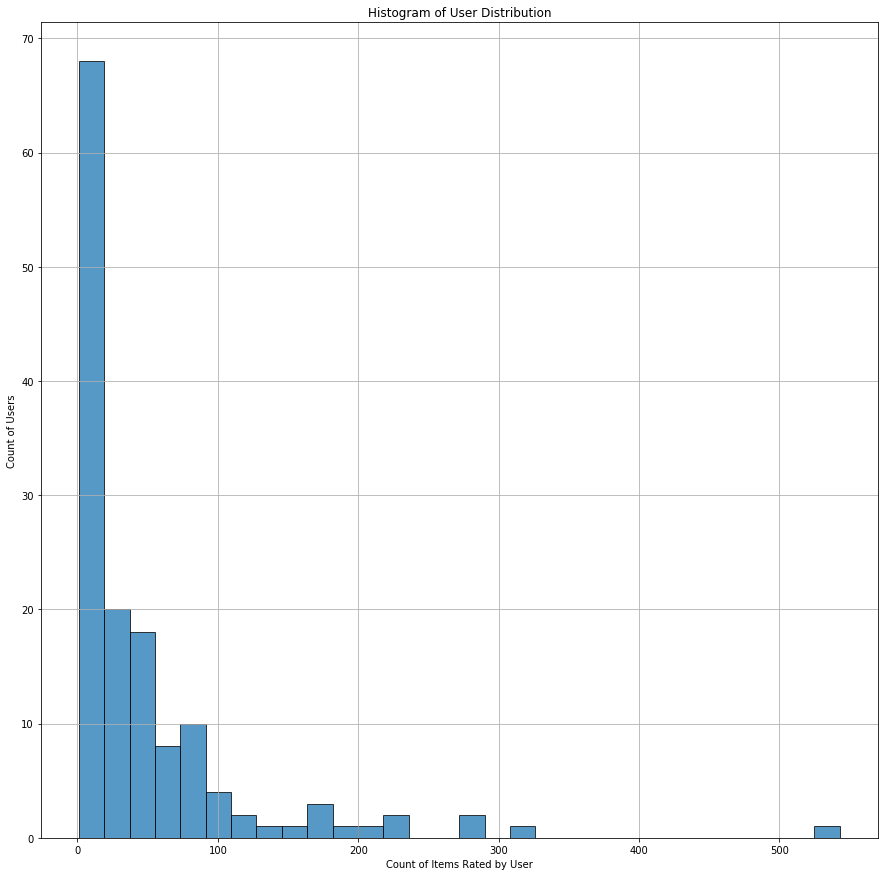

In [53]:
plt.figure(figsize=(15,15))
plt.xlabel('Count of Items Rated by User')
plt.ylabel('Count of Users')
plt.title('Histogram of User Distribution')
plt.grid(True)
plt.hist(game_df.groupby("User")["Rating"].count(), alpha=0.75, bins=30, edgecolor='black')

Most users only rated a few games, but a handful of users rated 80-100 games.

(array([  41.,   34.,   37.,   67.,  153.,  424., 1208., 1863., 1821.,
        1197.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

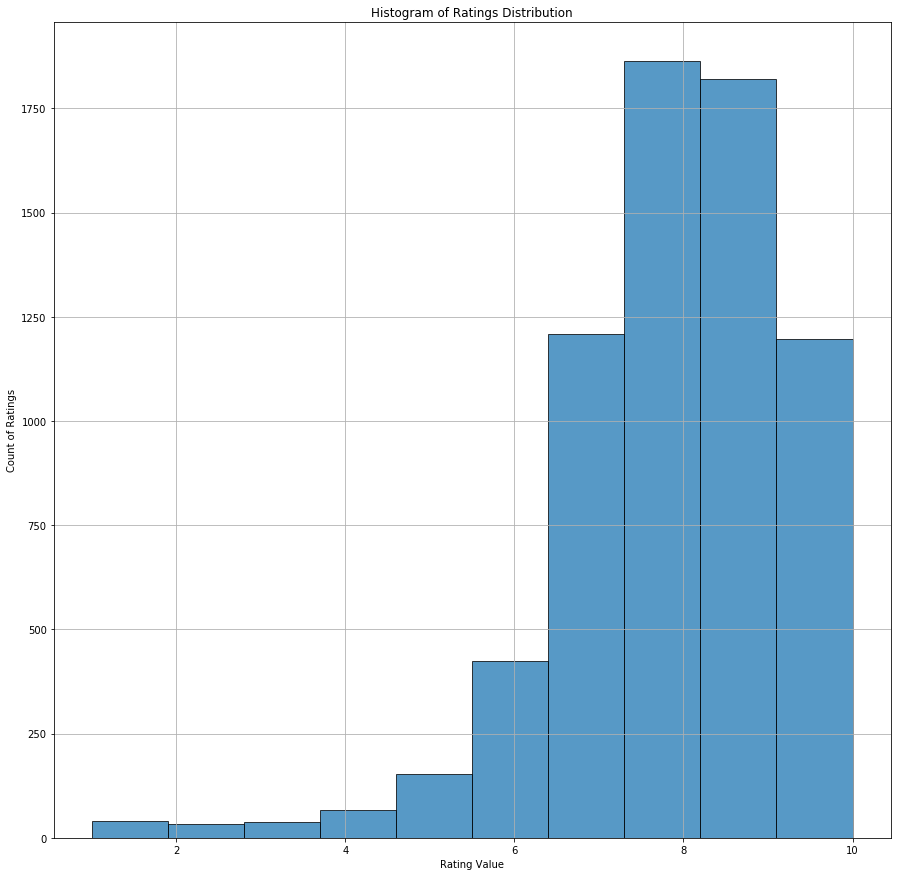

In [54]:
plt.figure(figsize=(15,15))
plt.xlabel('Rating Value')
plt.ylabel('Count of Ratings')
plt.title('Histogram of Ratings Distribution')
plt.grid(True)
plt.hist(game_df["Rating"], alpha=0.75, bins=10, edgecolor='black')

In [58]:
#Setting up naive user-based recommender
#Creating Similarity options and setting the methodology
from surprise.prediction_algorithms import KNNWithMeans
from surprise.model_selection import cross_validate, KFold
from surprise import accuracy
import numpy as np
sim_options_userbased = {'name': 'pearson',
                        'user_based': True}

user_based_cf = KNNWithMeans(sim_options=sim_options_userbased)

#Setting cross validation settings with a fixed random state of 1
kf = KFold(n_splits=5, random_state=np.random.seed(33))

userbased_results = []
for trainset, testset in kf.split(game_data):
    
    #Train and Test for Userbased
    user_based_cf.fit(trainset)
    predictions = user_based_cf.test(testset)
    
    # Compute, print and append RMSE to results list
    userbased_results.append(accuracy.rmse(predictions))

print("RMSE Results for 5 Folds for User Based Cross Validation: \n",userbased_results)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5441
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5682
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4433
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4857
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4970
RMSE Results for 5 Folds for User Based Cross Validation: 
 [1.5441432843245109, 1.568160245502547, 1.443301503769711, 1.4857457389632365, 1.4969835468904684]


In [60]:
#Comparing RMSEs with item-based
sim_options_itembased = {'name': 'pearson',
                        'user_based': True}

item_based_cf = KNNWithMeans(sim_options=sim_options_itembased)

#Setting cross validation settings with a fixed random state of 1
kf = KFold(n_splits=5, random_state=np.random.seed(33))

itembased_results = []
for trainset, testset in kf.split(game_data):
    
    #Train and Test for Userbased
    item_based_cf.fit(trainset)
    predictions = item_based_cf.test(testset)
    
    # Compute, print and append RMSE to results list
    itembased_results.append(accuracy.rmse(predictions))

print("RMSE Results for 5 Folds for Item Based Cross Validation: \n",itembased_results)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5441
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5682
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4433
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4857
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4970
RMSE Results for 5 Folds for Item Based Cross Validation: 
 [1.5441432843245109, 1.568160245502547, 1.443301503769711, 1.4857457389632365, 1.4969835468904684]


In [59]:
#Getting top 10 recommendations for each user
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# building trainset and fitting to our user-based KNN algo
trainset = game_data.build_full_trainset()
algo = KNNWithMeans(sim_options=sim_options_userbased)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Computing the pearson similarity matrix...
Done computing similarity matrix.
New_Guest ['Super Smash Bros. Ultimate', 'Diablo III: Eternal Collection', 'Undertale', 'Xenoblade Chronicles 2: Torna - The Golden Country', 'Captain Toad: Treasure Tracker', 'Sushi Striker: The Way of Sushido', 'Donkey Kong Country: Tropical Freeze', 'Bayonetta 2', 'Xenoblade Chronicles 2', 'The Elder Scrolls V: Skyrim']
Magician ['Mario Kart Tour', 'Disgaea DS', 'Pokémon Mystery Dungeon: Blue Rescue Team', 'La-Mulana', 'Fortune Street', 'MotoHeroz', 'Hydroventure', 'Art Style: Penta Tentacles', 'Art Style: light trax', 'WarioWare: D.I.Y. Showcase']
Arbor ['Donkey Kong Land', 'Wario Land: Super Mario Land 3', 'Super Mario Land 2: 6 Golden Coins', 'Teenage Mutant Ninja Turtles II: Back from the Sewers', 'Nintendo World Cup', 'Teenage Mutant Ninja Turtles: Fall of the Foot Clan', 'Super Mario Land', 'Tetris', "Dragon's Dogma: Dark Arisen", 'Our World is Ended']
UrsaBear ['Super Mario Land 2: 6 Golden Coins', '

In [61]:
type(top_n)

collections.defaultdict

In [64]:
#Getting top 10 neighbors for each item
# First, train the algortihm to compute the similarities between items
trainset = game_data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)



Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [69]:
game_df[100:110]

,User,Item,Rating,Unused
100,Magician,Bayonetta 2,9.0,None
101,Magician,The Longest Five Minutes,6.0,None
102,Magician,Monster Energy Supercross - The Official Video...,4.0,None
103,Magician,Dragon Quest Builders,8.0,None
104,Magician,Mercenary Kings Reloaded,7.0,None
105,Magician,Lost Sphear,7.0,None
106,Magician,RXN -Raijin-,7.0,None
107,Magician,The End Is Nigh,8.0,None
108,Magician,Party Planet,6.0,None
109,Magician,Stern Pinball Arcade,7.0,None


In [70]:
trainset.to_inner_iid("Bayonetta 2")

100

In [71]:
trainset.to_inner_iid("Dragon Quest Builders")

103

In [72]:
game_df[125:135]

,User,Item,Rating,Unused
125,Magician,DOOM,9.0,None
126,Magician,"Snipperclips Plus: Cut it out, together!",9.0,None
127,Magician,Sonic Forces,6.0,None
128,Magician,Cartoon Network: Battle Crashers,4.0,None
129,Magician,Monopoly for Nintendo Switch,6.0,None
130,Magician,Monster Jam: Crush It!,3.0,None
131,Magician,Super Mario Odyssey,9.0,None
132,Magician,Nights of Azure 2: Bride of the New Moon,7.0,None
133,Magician,Poi: Explorer Edition,7.0,None
134,Magician,This Is The Police,7.0,None


In [74]:
trainset.to_inner_iid("Super Mario Odyssey")

131

In [75]:
trainset.to_raw_iid(131)

'Super Mario Odyssey'

In [80]:
#Getting top 10 neighbors for each item
# First, train the algortihm to compute the similarities between items
trainset = game_data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)

# Retrieve inner id of the movie Toy Story
super_mario_odyssey_inner_id = algo.trainset.to_inner_iid("Super Mario Odyssey")
super_mario_odyssey_raw_id = algo.trainset.to_raw_iid(super_mario_odyssey_inner_id)

# Retrieve inner ids of the nearest neighbors of Super Mario Odyssey.
super_mario_odyssey_neighbors = algo.get_neighbors(super_mario_odyssey_inner_id, k=10)

# Convert inner ids of the neighbors into names.
super_mario_odyssey_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in super_mario_odyssey_neighbors)

# print(super_mario_odyssey_neighbors)
# toy_story_neighbors = (rid_to_name[rid]
#                        for rid in toy_story_neighbors)

print('The 10 nearest neighbors of Super Mario Odyssey are:')
for game in super_mario_odyssey_neighbors:
    print(game)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
The 10 nearest neighbors of Super Mario Odyssey are:
The Legend of Zelda: Breath of the Wild
Mario Kart 8
Mario Kart 8 Deluxe
The Legend of Zelda: The Wind Waker HD
Super Mario 3D World
Super Smash Bros. Ultimate
The Legend of Zelda: Skyward Sword
Xenoblade Chronicles 2
Yoshi's Woolly World
Metroid: Samus Returns


## Creating Games Metadata

In [14]:
def get_max_pages_thread(thread_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our thread
    url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a thread only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [26]:
#Setting url and debugging
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [27]:
r

<Response [200]>

In [28]:
soup

<!DOCTYPE html>

<html lang="en-GB">
<head>
<base href="http://www.nintendolife.com"/>
<meta content="ccms/0.2.0 (dgpCMS: http://nlife.com)" name="generator"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>All Switch eShop, Switch Games - Nintendo Life</title>
<meta content="#e60012" name="theme-color">
<meta content="#e60012" name="msapplication-navbutton-color">
<meta content="#e60012" name="apple-mobile-web-app-status-bar-style"/>
<meta content="D7560F5739AF48D918517B5AFC24A564" name="msvalidate.01"/>
<meta content="Nintendo Life" name="author"/>
<meta content="Nintendo Life" name="apple-mobile-web-app-title"/>
<meta content="width=device-width, initial-scale=1.0, user-scalable=0, minimum-scale=1.0, maximum-scale=1.0" id="viewport" name="viewport"/>
<link href="http://static.nintendolife.com/themes/nl.v10/css/stylesheet.css?accent=%23e60012&amp;v=1579882328" rel="stylesheet" type="text/css"/>
<link href="http://static.nintendolife.com/favicon.ico" rel="

In [29]:
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})

In [30]:
pagination_tags

[<a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=2" title="Goto Page 2">2</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=3" title="Goto Page 3">3</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=4" title="Goto Page 4">4</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=5" title="Goto Page 5">5</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=6" title="Goto Page 6">6</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;sys

In [31]:
page_tag_numbers = [1]

for tag in pagination_tags:
    page_tag_numbers.append(int(tag.contents[0]))
    max_page_tag = max(page_tag_numbers)

In [32]:
page_tag_numbers

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [33]:
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch&page=15"
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [34]:
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})

In [35]:
pagination_tags

[<a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=8" title="Goto Page 8">8</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=9" title="Goto Page 9">9</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=10" title="Goto Page 10">10</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=11" title="Goto Page 11">11</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=12" title="Goto Page 12">12</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cove

In [36]:
for tag in pagination_tags:
    if int(tag.contents[0]) not in page_tag_numbers:
        page_tag_numbers.append(int(tag.contents[0]))
    max_page_tag = max(page_tag_numbers)

In [37]:
page_tag_numbers

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [39]:
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#first pass
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})#just pagination tags
empty_checker = soup.findAll("li", {"class": "empty"})
page_tag_numbers = [1]
for tag in pagination_tags:
    page_tag_numbers.append(int(tag.contents[0]))
max_page_tag = max(page_tag_numbers)

In [40]:
pagination_tags

[<a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=2" title="Goto Page 2">2</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=3" title="Goto Page 3">3</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=4" title="Goto Page 4">4</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=5" title="Goto Page 5">5</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=6" title="Goto Page 6">6</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;sys

In [41]:
page_tag_numbers

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [42]:
empty_checker

[]

In [43]:
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch&page=58"
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#first pass
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})#just pagination tags
empty_checker = soup.findAll("li", {"class": "empty"})
page_tag_numbers = [1]
for tag in pagination_tags:
    page_tag_numbers.append(int(tag.contents[0]))
max_page_tag = max(page_tag_numbers)

In [44]:
pagination_tags

[<a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=51" title="Goto Page 51">51</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=52" title="Goto Page 52">52</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=53" title="Goto Page 53">53</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=54" title="Goto Page 54">54</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;style=cover&amp;system=switch-eshop%2Cnintendo-switch&amp;page=55" title="Goto Page 55">55</a>,
 <a class="accent accent-bg-hover accent-border" href="/games/browse?sort=popular&amp;styl

In [45]:
page_tag_numbers

[1, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65]

In [46]:
empty_checker

[]

In [48]:
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch&page=60"
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#first pass
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})#just pagination tags
empty_checker = soup.findAll("li", {"class": "empty"})
page_tag_numbers = [1]
for tag in pagination_tags:
    page_tag_numbers.append(int(tag.contents[0]))
max_page_tag = max(page_tag_numbers)

In [49]:
pagination_tags

[]

In [50]:
empty_checker

[<li class="empty">Sorry, there are no results at the moment</li>]

In [64]:
#Setting parameters and getting soup for our thread
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#first pass
pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
page_tag_numbers = [1]
for tag in pagination_tags:
    page_tag_numbers.append(int(tag.contents[0]))
max_page_tag = max(page_tag_numbers)

print("First Max Page Tag: ")
print(max_page_tag)

#Every pass therafter
empty_checker = []
while not empty_checker:
    new_url = url + "&page=" + str(max_page_tag)
    r = requests.get(new_url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})
    empty_checker = soup.findAll("li", {"class": "empty"})

    for tag in pagination_tags:
        if int(tag.contents[0]) not in page_tag_numbers:
            page_tag_numbers.append(int(tag.contents[0]))
    max_page_tag = max(page_tag_numbers)
    print("Next Set of page tags: ")
    print(page_tag_numbers)

First Max Page Tag: 
15
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Next Set of page tags: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

In [94]:
def get_max_pages_gamepage(url):
    """
    :params url: url for games page
    : return max_page_tag: max numer of pages for games page
    """

    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #first pass
    pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
    page_tag_numbers = [1]
    for tag in pagination_tags:
        page_tag_numbers.append(int(tag.contents[0]))
    max_page_tag = max(page_tag_numbers)

    #Every pass therafter
    empty_checker = []
    while not empty_checker:
        new_url = url + "&page=" + str(max_page_tag)
        r = requests.get(new_url) 
        html_text = r.text
        soup = BeautifulSoup(html_text, "html.parser")

        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})
        empty_checker = soup.findAll("li", {"class": "empty"})

        for tag in pagination_tags:
            if int(tag.contents[0]) not in page_tag_numbers:
                page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
    
    return max_page_tag

In [66]:
page_test = get_max_pages_gamepage("http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch")

In [67]:
page_test

64

In [68]:
#Getting Games URLs
#Setting parameters and getting soup for our thread
url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#Getting Game Tags
game_tags = soup.findAll("a", {"class": "title accent-hover"})

In [70]:
tag2 = game_tags[2]

In [71]:
tag2

<a class="title accent-hover" href="games/nintendo-switch/super_smash_bros_ultimate"><span class="title accent-hover">Super Smash Bros. Ultimate</span> <span class="subtitle">Switch</span></a>

In [74]:
tag2.attrs["href"]

'games/nintendo-switch/super_smash_bros_ultimate'

In [79]:
game_urls = []

for tag in game_tags:
    link = tag.attrs["href"]
    if link[0:5] == "games":
        game_urls.append(link)
    else:
        pass

In [80]:
game_urls

['games/nintendo-switch/genshin_impact',
 'games/nintendo-switch/animal_crossing_new_horizons',
 'games/nintendo-switch/super_smash_bros_ultimate',
 'games/nintendo-switch/pokemon_sword_and_shield',
 'games/nintendo-switch/legend_of_zelda_breath_of_the_wild',
 'games/nintendo-switch/dragon_quest_xi_s_echoes_of_an_elusive_age_-_definitive_edition',
 'games/nintendo-switch/tokyo_mirage_sessions_fe_encore',
 'games/nintendo-switch/gods_and_monsters',
 'games/nintendo-switch/witcher_3_wild_hunt_-_complete_edition',
 'games/nintendo-switch/cave_storyplus',
 'games/nintendo-switch/mario_kart_8_deluxe',
 'games/nintendo-switch/persona_5_scramble_the_phantom_strikers',
 'games/switch-eshop/to_the_moon',
 'games/nintendo-switch/dead_cells',
 'games/switch-eshop/pixeljunk_monsters_2',
 'games/nintendo-switch/astral_chain',
 'games/nintendo-switch/luigis_mansion_3',
 'games/nintendo-switch/fire_emblem_three_houses',
 'games/nintendo-switch/mario_plus_rabbids_kingdom_battle',
 'games/nintendo-swit

In [81]:
page_test

64

In [89]:
game_urls = []

for page in range(1, page_test+1):
    if page == 1:
        url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
        r = requests.get(url) 
        html_text = r.text
        soup = BeautifulSoup(html_text, "html.parser")
        
        #Getting Game Tags
        game_tags = soup.findAll("a", {"class": "title accent-hover"})
        for game in game_tags:
            game_link = game.attrs["href"]
            if game_link[0:5] == "games":
                game_urls.append(game_link)
            else:
                pass
    else:
        url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch" + "&page=" + str(page) 
        r = requests.get(url) 
        html_text = r.text
        soup = BeautifulSoup(html_text, "html.parser")
        
        #Getting Game Tags
        game_tags = soup.findAll("a", {"class": "title accent-hover"})
        for game in game_tags:
            game_link = game.attrs["href"]
            if game_link[0:5] == "games":
                game_urls.append(game_link)
            else:
                pass

In [86]:
len(game_urls)

3474

In [97]:
#get games url list

def get_game_urls(max_pages):
    '''Function for getting list of game urls from games page on Nintendolife.com'''
    game_urls = []

    for page in range(1, max_pages+1):
        if page == 1:
            url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch"
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")

            #Getting Game Tags
            game_tags = soup.findAll("a", {"class": "title accent-hover"})
            for game in game_tags:
                game_link = game.attrs["href"]
                if game_link[0:5] == "games":
                    game_urls.append(game_link)
                else:
                    pass
        else:
            url = "http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch" + "&page=" + str(page) 
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")

            #Getting Game Tags
            game_tags = soup.findAll("a", {"class": "title accent-hover"})
            for game in game_tags:
                game_link = game.attrs["href"]
                if game_link[0:5] == "games":
                    game_urls.append(game_link)
                else:
                    pass
    return game_urls

In [98]:
max_game_pages = get_max_pages_gamepage("http://www.nintendolife.com/games/browse?sort=popular&style=cover&system=switch-eshop%2Cnintendo-switch")

In [99]:
max_game_pages

64

In [100]:
game_urls = get_game_urls(game_pages)

In [101]:
print(len(game_urls))

3474


In [102]:
##Getting Game data for all of our games
#testing with one game first
url = "http://www.nintendolife.com/games/nintendo-switch/super_smash_bros_ultimate"
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#Things that I want to get from the website: Publisher, Developer, Number of players, 
#Genre, price

In [211]:
#Finding System, developer and publisher

info = soup.findAll("dd", {"class": "first"})

In [212]:
info

[<dd class="first">Nintendo Switch</dd>,
 <dd class="first">Nintendo</dd>,
 <dd class="first">Nintendo</dd>,
 <dd class="first">8</dd>,
 <dd class="first"><a href="/games/browse?system=nintendo-switch&amp;genre=action&amp;sort=score">Action</a>, <a href="/games/browse?system=nintendo-switch&amp;genre=fighting&amp;sort=score">Fighting</a></dd>,
 <dd class="first"><p>Nintendo Switch</p>
 <ul><li class="first">7th Dec 2018 (<abbr title="North America (United States, Canada etc.)">US/Canada</abbr>), $59.99</li><li class="last">7th Dec 2018 (<abbr title="UK, Europe and Austrailia">UK/EU/AU</abbr>), £59.99</li></ul>
 </dd>,
 <dd class="first"><a href="/games/browse?title=series%3Asmash_bros">Smash Bros</a></dd>]

In [127]:
#The dd class has system, developer, publisher, number of players, genres, prices
for tag in info:
    print(tag.contents)

['Nintendo Switch']
['Nintendo']
['Nintendo']
['8']
[<a href="/games/browse?system=nintendo-switch&amp;genre=action&amp;sort=score">Action</a>, ', ', <a href="/games/browse?system=nintendo-switch&amp;genre=fighting&amp;sort=score">Fighting</a>]
[<p>Nintendo Switch</p>, '\n', <ul><li class="first">7th Dec 2018 (<abbr title="North America (United States, Canada etc.)">US/Canada</abbr>), $59.99</li><li class="last">7th Dec 2018 (<abbr title="UK, Europe and Austrailia">UK/EU/AU</abbr>), £59.99</li></ul>, '\n']
[<a href="/games/browse?title=series%3Asmash_bros">Smash Bros</a>]


In [128]:
info_list = []

In [136]:
for tag in info:
    print(len(tag.contents))

1
1
1
1
3
4
1


In [135]:
info

[<dd class="first">Nintendo Switch</dd>,
 <dd class="first">Nintendo</dd>,
 <dd class="first">Nintendo</dd>,
 <dd class="first">8</dd>,
 <dd class="first"><a href="/games/browse?system=nintendo-switch&amp;genre=action&amp;sort=score">Action</a>, <a href="/games/browse?system=nintendo-switch&amp;genre=fighting&amp;sort=score">Fighting</a></dd>,
 <dd class="first"><p>Nintendo Switch</p>
 <ul><li class="first">7th Dec 2018 (<abbr title="North America (United States, Canada etc.)">US/Canada</abbr>), $59.99</li><li class="last">7th Dec 2018 (<abbr title="UK, Europe and Austrailia">UK/EU/AU</abbr>), £59.99</li></ul>
 </dd>,
 <dd class="first"><a href="/games/browse?title=series%3Asmash_bros">Smash Bros</a></dd>]

In [213]:
#Gets us platform, developer, publisher, number of players
info = soup.findAll("dd", {"class": "first"})
info_list = []
for tag in info:
    if len(tag.contents) == 1:
        info_list.append(tag.contents[0])

info_list.pop()
print(info_list)

['Nintendo Switch', 'Nintendo', 'Nintendo', '8']


In [214]:
#Getting genre
genre_tags = soup.findAll("a")

genre_list = []
for element in genre_tags:
    if "genre" in element.attrs["href"]:
        genre_list.append(element.contents[0])
print(genre_list)

['Action', 'Fighting']


In [239]:
#Getting Game Name
game_tags = soup.findAll("h1")
for tag in game_tags:
    print(tag.contents[0].contents[0])

Super Smash Bros. Ultimate (Switch)


In [240]:
#Putting it all together

games_test = game_urls[0:10]
print(games_test)

['games/nintendo-switch/genshin_impact', 'games/nintendo-switch/animal_crossing_new_horizons', 'games/nintendo-switch/super_smash_bros_ultimate', 'games/nintendo-switch/pokemon_sword_and_shield', 'games/nintendo-switch/legend_of_zelda_breath_of_the_wild', 'games/nintendo-switch/dragon_quest_xi_s_echoes_of_an_elusive_age_-_definitive_edition', 'games/nintendo-switch/gods_and_monsters', 'games/nintendo-switch/tokyo_mirage_sessions_fe_encore', 'games/nintendo-switch/witcher_3_wild_hunt_-_complete_edition', 'games/nintendo-switch/cave_storyplus']


In [257]:
one_game = games_test[4]

In [258]:
one_game

'games/nintendo-switch/legend_of_zelda_breath_of_the_wild'

In [267]:
info_list = []
genre_list = []

url = "http://www.nintendolife.com/" + one_game
r = requests.get(url)
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

#Getting Game Name
game_tags = soup.findAll("h1")
for tag in game_tags:
    game_title = tag.contents[0].contents[0]

print("game_title: ", game_title)

#Gets us platform, developer, publisher, number of players
info = soup.findAll("dd", {"class": "first"})
for tag in info:
    if len(tag.contents) == 1:
        info_list.append(tag.contents[0])


platform = info_list[0]
developer = info_list[1]
publisher = info_list[2]

print("platform: ", platform)
print("developer: ", developer)
print("publisher: ", publisher)

#Getting genre
genre_tags = soup.findAll("a")
for element in genre_tags:
    if "genre" in element.attrs["href"]:
        genre_list.append(element.contents[0])
        
print("genre: ", genre_list)
        
keys = ["game_title", "platform", "developer", "publisher", "genre"]
values = [game_title, platform, developer, publisher, genre_list]

my_dict = dict(zip(keys, values))
print(my_dict)

game_title:  The Legend of Zelda: Breath of the Wild (Switch)
platform:  Nintendo Switch
developer:  Nintendo
publisher:  Nintendo SPD
genre:  ['Action', 'Adventure']
{'game_title': 'The Legend of Zelda: Breath of the Wild (Switch)', 'platform': 'Nintendo Switch', 'developer': 'Nintendo', 'publisher': 'Nintendo SPD', 'genre': ['Action', 'Adventure']}


In [268]:
games_test

['games/nintendo-switch/genshin_impact',
 'games/nintendo-switch/animal_crossing_new_horizons',
 'games/nintendo-switch/super_smash_bros_ultimate',
 'games/nintendo-switch/pokemon_sword_and_shield',
 'games/nintendo-switch/legend_of_zelda_breath_of_the_wild',
 'games/nintendo-switch/dragon_quest_xi_s_echoes_of_an_elusive_age_-_definitive_edition',
 'games/nintendo-switch/gods_and_monsters',
 'games/nintendo-switch/tokyo_mirage_sessions_fe_encore',
 'games/nintendo-switch/witcher_3_wild_hunt_-_complete_edition',
 'games/nintendo-switch/cave_storyplus']

In [271]:
game_metadata = []


for game in games_test:
    url = "http://www.nintendolife.com/" + game
    r = requests.get(url)
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")
    
    #Getting Game Name
    game_tags = soup.findAll("h1")
    for tag in game_tags:
        game_title = tag.contents[0].contents[0]

    #Gets us platform, developer, publisher, number of players
    info = soup.findAll("dd", {"class": "first"})
    info_list=[]
    for tag in info:
        if len(tag.contents) == 1:
            info_list.append(tag.contents[0])

    platform = info_list[0]
    developer = info_list[1]
    publisher = info_list[2]
    
    #Getting genre
    genre_tags = soup.findAll("a")
    genre_list = []
    for element in genre_tags:
        if "genre" in element.attrs["href"]:
            genre_list.append(element.contents[0])
            
    keys = ["game_title", "platform", "developer", "publisher", "genre"]
    values = [game_title, platform, developer, publisher, genre_list]
    
    game_dict = dict(zip(keys, values))
    game_metadata.append(game_dict)

df = pd.DataFrame(game_metadata)
df

,developer,game_title,genre,platform,publisher
0,Announced,Genshin Impact (Switch),"[Action, Adventure, RPG]",Nintendo Switch,"<a href=""https://genshin.mihoyo.com/en"" rel=""e..."
1,Nintendo,Animal Crossing: New Horizons (Switch),"[Adventure, Puzzle, Simulation]",Nintendo Switch,Nintendo
2,Nintendo,Super Smash Bros. Ultimate (Switch),"[Action, Fighting]",Nintendo Switch,Nintendo
3,Nintendo,Pokémon Sword and Shield (Switch),[RPG],Nintendo Switch,Game Freak
4,Nintendo,The Legend of Zelda: Breath of the Wild (Switch),"[Action, Adventure]",Nintendo Switch,Nintendo SPD
5,Square Enix,Dragon Quest XI S: Echoes of an Elusive Age - ...,[RPG],Nintendo Switch,Square Enix
6,Ubisoft,Gods & Monsters (Switch),[],Nintendo Switch,Ubisoft Quebec
7,Nintendo,Tokyo Mirage Sessions #FE Encore (Switch),[RPG],Nintendo Switch,Atlus
8,CD Projekt Red,The Witcher 3: Wild Hunt - Complete Edition (S...,"[Action, RPG]",Nintendo Switch,CD Projekt Red
9,Nicalis,Cave Story+ (Switch),"[Action, Adventure, Platformer]",Nintendo Switch,Nicalis


In [41]:
def get_game_metadata(games_list):
    '''Function for getting metadata for games'''
    #List for appending game metadata
    game_metadata = []

    for game in games_list:
        url = "http://www.nintendolife.com/" + game
        r = requests.get(url)
        html_text = r.text
        soup = BeautifulSoup(html_text, "html.parser")

        #Getting Game Name
        game_tags = soup.findAll("h1")
        for tag in game_tags:
            game_title = tag.contents[0].contents[0]

        #Gets us platform, developer, publisher, number of players
        info = soup.findAll("dd", {"class": "first"})
        info_list=[]
        for tag in info:
            if len(tag.contents) == 1:
                info_list.append(tag.contents[0])
        try:
            platform = info_list[0]
            developer = info_list[1]
            publisher = info_list[2]
        except:
            publisher = "N/A"

        #Getting genre
        genre_tags = soup.findAll("a")
        genre_list = []
        for element in genre_tags:
            if "genre" in element.attrs["href"]:
                genre_list.append(element.contents[0])

        keys = ["game_title", "platform", "developer", "publisher", "genre"]
        values = [game_title, platform, developer, publisher, genre_list]

        game_dict = dict(zip(keys, values))
        game_metadata.append(game_dict)
        
        if len(game_metadata) % 50 == 0:
            print(len(game_metadata))
        
    df = pd.DataFrame(game_metadata)
    return df

In [291]:
game_meta = get_game_metadata(game_urls)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450


In [290]:
game_meta

,developer,game_title,genre,platform,publisher
0,Announced,Genshin Impact (Switch),"[Action, Adventure, RPG]",Nintendo Switch,"<a href=""https://genshin.mihoyo.com/en"" rel=""e..."
1,Nintendo,Animal Crossing: New Horizons (Switch),"[Adventure, Puzzle, Simulation]",Nintendo Switch,Nintendo
2,Nintendo,Super Smash Bros. Ultimate (Switch),"[Action, Fighting]",Nintendo Switch,Nintendo
3,Nintendo,Pokémon Sword and Shield (Switch),[RPG],Nintendo Switch,Game Freak
4,Nintendo,The Legend of Zelda: Breath of the Wild (Switch),"[Action, Adventure]",Nintendo Switch,Nintendo SPD
5,Square Enix,Dragon Quest XI S: Echoes of an Elusive Age - ...,[RPG],Nintendo Switch,Square Enix
6,Ubisoft,Gods & Monsters (Switch),[],Nintendo Switch,Ubisoft Quebec
7,Nintendo,Tokyo Mirage Sessions #FE Encore (Switch),[RPG],Nintendo Switch,Atlus
8,CD Projekt Red,The Witcher 3: Wild Hunt - Complete Edition (S...,"[Action, RPG]",Nintendo Switch,CD Projekt Red
9,Nicalis,Cave Story+ (Switch),"[Action, Adventure, Platformer]",Nintendo Switch,Nicalis


In [295]:
thread_pages = get_max_pages_thread("what_do_you_think_the_nx_is_poll")
print(thread_pages)

2375


In [2]:
def get_users(thread_name, max_pages):
    '''Function for collecting all users from a thread. 
    Params: thread name (string), max number of pages
    returns :De-duplicated list of users'''
    
    users = []
    for i in range(max_pages):
        n_posts = i * 20
        if n_posts == 0:            
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])

        else:           
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name + "?start=" + str(n_posts)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])
                
        if len(users) % 2000 == 0:
            print(len(users))
                
    #Deduplicating List
    deduped_users = list(set(users))
    return deduped_users

## Building out bigger Dataset for Algorithm Analysis

In [6]:
def get_max_pages_thread(thread_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our thread
    url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a thread only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [7]:
thread_pages = get_max_pages_thread("what_do_you_think_the_nx_is_poll")
print(thread_pages)

2375


In [8]:
users = get_users("what_do_you_think_the_nx_is_poll", thread_pages)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000


In [9]:
print(len(users))

756


In [10]:
thread_pages2 = get_max_pages_thread("the_switch_eshop_recommendations")
print(thread_pages2)

56


In [11]:
users2 = get_users("the_switch_eshop_recommendations", thread_pages2)

In [12]:
len(users2)

275

In [13]:
users.extend(users2)

In [14]:
print(len(users))

1031


In [15]:
users = list(set(users))

In [16]:
print(len(users))

887


887 total users in our list. Let's get their games

In [17]:
def get_max_pages(user_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our user
    url = "https://www.nintendolife.com/users/" + user_name + "/games"
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a user only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [18]:
#Creating Function for getting games and ratings into dataframe=
def games_ratings_to_df(user_name, max_pages):
    '''Function for putting a user's games
    and ratings into a dataframe'''
    
    #Setting up object holders
    cols = ["User", "Game", "Rating"]
    df = pd.DataFrame(columns=cols)
    games = []
    ratings = []
    
    #iterating through pages
    for page in range(1, max_pages+1):
        #Url is different if on first page rather than other pages
        if page == 1:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games"
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
        #Adding the rest of the url pages       
        else:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games?page=" + str(page)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
    
    #Adding our games and ratings list to dataframe
    df["Game"] = games
    df["Rating"] = ratings
    df["User"] = user_name
    
    return df

In [19]:
print(len(users))

887


In [20]:
df = pd.DataFrame()

for user in users:
    max_pages = get_max_pages(user)
    user_games_ratings = games_ratings_to_df(user, max_pages)
    df = df.append(user_games_ratings)
    print(len(df))

3
45
45
47
92
110
111
201
224
260
260
260
271
331
331
588
590
623
623
626
626
627
1418
1418
1418
1470
1470
1470
1496
1496
1496
1497
1507
1547
1581
1748
1810
1829
1877
1885
1885
1897
1902
1950
1950
1950
1950
1950
1950
1950
1950
2003
2011
2011
2011
2011
2032
2234
2234
2255
2375
2375
2380
2924
2924
2958
2958
2958
2958
2959
2959
2986
2994
3001
3019
3027
3112
3112
3112
3112
3114
3118
3118
3118
3118
3118
3119
3123
3123
3128
3128
3128
3128
3128
3128
3131
3389
3389
3429
3718
3718
3718
3718
3769
3782
3782
3782
3782
3782
3782
4350
4360
4360
4369
4369
4435
4435
4435
4435
4458
4460
4460
4460
4460
4561
4670
4676
4847
4847
4847
4847
4847
4847
4847
4941
4941
4941
4941
5000
5001
5001
5001
5003
5003
5039
5039
5098
5102
5102
5102
5102
5144
5149
5372
5372
5392
5400
5400
5400
5400
6045
6164
6164
6170
6170
6170
6170
6186
6186
6311
6311
6314
6314
6325
6480
6480
6539
6539
6539
6541
6647
6647
6690
6690
6701
6704
6704
6704
6855
6869
6869
6922
6922
6922
6931
7075
7083
7083
7083
7083
7094
7154
7154
7154
7154
715

In [ ]:
print("hello world")

In [21]:
df.head(10)

,User,Game,Rating
0,dumedum,The Legend of Zelda: Breath of the Wild,10
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10
2,dumedum,Darkman,10
0,Action51,Pokémon Sun and Moon,9
1,Action51,Twisted Fusion,7
2,Action51,Star Fox Zero,7
3,Action51,Fire Emblem Fates,7
4,Action51,Xenoblade Chronicles X,8
5,Action51,Super Mario Maker,9
6,Action51,Code Name: S.T.E.A.M.,9


In [22]:
df.tail(10)

,User,Game,Rating
211,DockEllisD,Super Mario World,10
212,DockEllisD,Battletoads,10
213,DockEllisD,Double Dragon III: The Sacred Stones,8
214,DockEllisD,Super Mario Bros. 3,10
215,DockEllisD,Double Dragon II: The Revenge,9
216,DockEllisD,Zelda II: The Adventure of Link,6
217,DockEllisD,Double Dragon,7
218,DockEllisD,The Legend of Zelda,10
219,DockEllisD,Super Mario Bros.,10
220,DockEllisD,Kunio-kun: The World Classics Collection,No Score


In [24]:
import os
print(os.getcwd())

/Users/josephberkowitz/Desktop/SharpestMinds/SharpestMindsProject/Nintendo_Project


In [25]:
df.shape

(27555, 3)

In [26]:
df.to_csv("data.csv", index=False)

### Updating User Function to Pull List of Game URLs

In [2]:
#importing necessary libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

In [3]:
def get_max_pages(user_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our user
    url = "https://www.nintendolife.com/users/" + user_name + "/games"
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a user only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [4]:
pages = get_max_pages("link3710")

In [5]:
pages

4

In [33]:
#Creating Function for getting games and ratings into dataframe
def games_ratings_to_df(user_name, max_pages):
    """
    :params user_name: user_name
    :params max_pages: max_pages from function get_max_pages()
    : return df: scraped pandas dataframe for user_name
    : return game_urls: list of urls for games listed on user page
    """
    
    #Setting up object holders
    cols = ["User", "Game", "Rating"]
    df = pd.DataFrame(columns=cols)
    games = []
    ratings = []
    game_urls = []
    
    #iterating through pages
    for page in range(1, max_pages+1):
        #Url is different if on first page rather than other pages
        if page == 1:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games"
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            
            #Getting game urls
            hrefs = soup.findAll("a", {"class": "title accent-hover"})
            try:
                for i in range(len(hrefs)):
                    url = hrefs[i].attrs["href"]
                    game_urls.append(url)
            except:
                pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
        #Adding the rest of the url pages       
        else:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games?page=" + str(page)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
                
            #Getting game urls
            hrefs = soup.findAll("a", {"class": "title accent-hover"})
            for i in range(len(hrefs)):
                url = hrefs[i].attrs["href"]
                game_urls.append(url)
                
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
    
    #Adding our games and ratings list to dataframe
    df["Game"] = games
    df["Rating"] = ratings
    df["User"] = user_name
    
    game_urls = list(set(game_urls))
    
    return df, game_urls

In [7]:
#Setting parameters and getting first soup for our user
url = "https://www.nintendolife.com/users/link3710/games"
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [8]:
hrefs = soup.findAll("a", {"class": "title accent-hover"})

In [15]:
hrefs[0].attrs['href']

'games/nintendo-switch/daemon_x_machina'

In [16]:
game_urls = []
for i in range(len(hrefs)):
    url = hrefs[i].attrs["href"]
    game_urls.append(url)

In [17]:
game_urls

['games/nintendo-switch/daemon_x_machina',
 'games/nintendo-switch/spyro_reignited_trilogy',
 'games/switch-eshop/gato_roboto',
 'games/switch-eshop/deltarune_chapter_1',
 'games/nintendo-switch/super_smash_bros_ultimate',
 'games/switch-eshop/katamari_damacy_reroll',
 'games/switch-eshop/horizon_chase_turbo',
 'games/nintendo-switch/dragon_ball_fighterz',
 'games/switch-eshop/undertale',
 'games/switch-eshop/okami_hd',
 'games/switch-eshop/yokus_island_express',
 'games/nintendo-switch/bayonetta_2',
 'games/switch-eshop/bayonetta',
 'games/nintendo-switch/lost_sphear',
 'games/nintendo-switch/xenoblade_chronicles_2',
 'games/mobile/animal_crossing_pocket_camp',
 'games/nintendo-switch/mxgp_3',
 'games/nintendo-switch/superbeat_xonic',
 'games/nintendo-switch/lumo',
 'games/3ds/pokemon_ultra_sun_and_ultra_moon',
 'games/nintendo-switch/batman_-_the_telltale_series',
 'games/nintendo-switch/ittle_dew_2plus',
 'games/nintendo-switch/lego_marvel_super_heroes_2',
 'games/switch-eshop/rocke

In [20]:
pages

4

In [21]:
games, game_urls = games_ratings_to_df("link3710", pages)

In [22]:
games

,User,Game,Rating
0,link3710,Daemon X Machina,No Score
1,link3710,Spyro Reignited Trilogy,9
2,link3710,Gato Roboto,8
3,link3710,DELTARUNE Chapter 1,9
4,link3710,Super Smash Bros. Ultimate,10
5,link3710,Katamari Damacy REROLL,9
6,link3710,Horizon Chase Turbo,8
7,link3710,Dragon Ball FighterZ,8
8,link3710,Undertale,9
9,link3710,Okami HD,9


In [23]:
game_urls

['games/nintendo-switch/daemon_x_machina',
 'games/nintendo-switch/spyro_reignited_trilogy',
 'games/switch-eshop/gato_roboto',
 'games/switch-eshop/deltarune_chapter_1',
 'games/nintendo-switch/super_smash_bros_ultimate',
 'games/switch-eshop/katamari_damacy_reroll',
 'games/switch-eshop/horizon_chase_turbo',
 'games/nintendo-switch/dragon_ball_fighterz',
 'games/switch-eshop/undertale',
 'games/switch-eshop/okami_hd',
 'games/switch-eshop/yokus_island_express',
 'games/nintendo-switch/bayonetta_2',
 'games/switch-eshop/bayonetta',
 'games/nintendo-switch/lost_sphear',
 'games/nintendo-switch/xenoblade_chronicles_2',
 'games/mobile/animal_crossing_pocket_camp',
 'games/nintendo-switch/mxgp_3',
 'games/nintendo-switch/superbeat_xonic',
 'games/nintendo-switch/lumo',
 'games/3ds/pokemon_ultra_sun_and_ultra_moon',
 'games/nintendo-switch/batman_-_the_telltale_series',
 'games/nintendo-switch/ittle_dew_2plus',
 'games/nintendo-switch/lego_marvel_super_heroes_2',
 'games/switch-eshop/rocke

In [24]:
#Function for getting max pages from the games page
def get_max_pages_gamepage(url):
    """
    Function for getting max number of pages from a game page
    :params url: url for games page
    : returns max_page_tag: max numer of pages for games page
    """

    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #first pass
    pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
    page_tag_numbers = [1]
    for tag in pagination_tags:
        page_tag_numbers.append(int(tag.contents[0]))
    max_page_tag = max(page_tag_numbers)

    #Every pass therafter
    empty_checker = []
    while not empty_checker:
        new_url = url + "&page=" + str(max_page_tag)
        r = requests.get(new_url) 
        html_text = r.text
        soup = BeautifulSoup(html_text, "html.parser")

        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})
        empty_checker = soup.findAll("li", {"class": "empty"})

        for tag in pagination_tags:
            if int(tag.contents[0]) not in page_tag_numbers:
                page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
    
    return max_page_tag

In [26]:
#Function for getting URLs for each game
def get_game_urls(url, max_pages):
    '''Function for getting list of game urls from games page on Nintendolife.com
    params: url: URL of games page - can be filtered for specific system
    params: max_pages: maximum number of pages for games page
    : returns: list of urls for each game
    '''
    game_urls = []

    for page in range(1, max_pages+1):
        if page == 1:
            url = url
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
    
            #Getting Game Tags
            game_tags = soup.findAll("a", {"class": "title accent-hover"})
            for game in game_tags:
                game_link = game.attrs["href"]
                if game_link[0:5] == "games":
                    game_urls.append(game_link)
                else:
                    pass
        else:
            url = url + "&page=" + str(page) 
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
    
            #Getting Game Tags
            game_tags = soup.findAll("a", {"class": "title accent-hover"})
            for game in game_tags:
                game_link = game.attrs["href"]
                if game_link[0:5] == "games":
                    game_urls.append(game_link)
                else:
                    pass
    return game_urls

In [30]:
thread_pages = get_max_pages_thread("the_switch_eshop_recommendations")
thread_users = get_users("the_switch_eshop_recommendations", thread_pages)

In [38]:
df = pd.DataFrame()
game_urls = []

for user in thread_users:
    max_pages = get_max_pages(user)
    user_games_ratings, urls = games_ratings_to_df(user, max_pages)
    df = df.append(user_games_ratings)
    game_urls.extend(urls)
    

In [39]:
df.head()

,User,Game,Rating
0,SKTTR,Shovel Knight: King Of Cards,9
1,SKTTR,REKT! High Octane Stunts,6
2,SKTTR,Luigi's Mansion 3,10
3,SKTTR,Reventure,8
4,SKTTR,Mario Kart Tour,10


In [40]:
game_urls[0:5]

['games/nintendo-switch/binding_of_isaac_afterbirthplus',
 'games/wii/legend_of_zelda_skyward_sword',
 'games/switch-eshop/baobabs_mausoleum_ep_2_1313_barnabas_dead_end_drive',
 'games/switch-eshop/rogue_bit',
 'games/gamecube/legend_of_zelda_four_swords_adventures']

In [42]:
games_meta = get_game_metadata(game_urls)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200


KeyboardInterrupt: 

In [43]:
len(game_urls)

10172

In [44]:
game_urls = list(set(game_urls))

In [45]:
len(game_urls)

2734

In [46]:
games_meta = get_game_metadata(game_urls)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700


In [48]:
games_meta

,developer,game_title,genre,platform,publisher
0,Konami,Beyond the Labyrinth (3DS),[RPG],3DS,tri-Ace
1,Sunsoft,Batman: The Video Game (NES),[Platformer],NES,Sunsoft
2,Kitfox Games,Moon Hunters (Switch eShop),"[Action, RPG]",Switch eShop,Kitfox Games
3,Electronic Arts,The Sims 3 (DS),"[Creative, Other, Simulation]",DS,Exient
4,Nintendo,Mario & Luigi: Superstar Saga + Bowser's Minio...,"[Adventure, RPG]",3DS,AlphaDream
5,Ubisoft,Lost Magic (DS),[Adventure],DS,Taito
6,Nintendo,Pokémon Emerald (GBA),[RPG],Game Boy Advance,Game Freak
7,Nintendo,Electroplankton Hanenbow (DSiWare),[Music],DSiWare,indies zero
8,Nintendo,Nintendo Land (Wii U),[Party],Wii U,Nintendo EAD
9,SEGA,Shining Resonance Refrain (Switch),"[Action, RPG]",Nintendo Switch,SEGA
